# Error Analysis

<img src="./../rsrc/idea.png" alt="Explanation Image" width="50" height="50">

<div style="border: 2px solid green; padding: 10px;">
In this notebook we will study the errors made by the model we have selected.
</div>

In [186]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModel
from datasets import load_dataset
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.parsing.preprocessing import (
    stem_text,
    remove_stopwords
)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import umap
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from nltk import word_tokenize
import wordcloud
import torch
from torch.nn.functional import cross_entropy

In [131]:
model = AutoModelForSequenceClassification.from_pretrained("../training/transformers/gte-base-lazy-teacher-v2",
                                                           trust_remote_code=True).to("mps")

tokenizer = AutoTokenizer.from_pretrained("../training/transformers/gte-base-lazy-teacher-v2",
                                            trust_remote_code=True)

In [132]:
data = load_dataset("csv", data_files="../../data/val_under.csv", split="train")

In [133]:
print(data[0])

{'corrected_text': 'the reason have not got venus yet because all the dangers that are stopping from getting there there are many reasons but the main reasons because hot land the surface even tho not the closest then sun the hottest planet since the hottest plainest cant get close with out burning death cant land there hillhaven find way grt close possible without dieting another reason the amount pressure the planet strong that would crash submarine that made for going and being able stay high pressure and not crush break but where venus wuld crud like person crushing peirce paper think have found way get close could use limb type system and stay miles above the planet the tempur would still degrees and thats still hot but used solor power from the sun should stay nice and cool inside the limb the last reason our technology not strong enough stand the heat would melt and then there was point going take like pictures and would kinda waste money need technology that would help then sta

In [134]:
def tokenize(batch):
    return tokenizer(batch["text"], return_tensors="pt", padding=True)

In [135]:
data = data.rename_column("corrected_text", "text")
data = data.map(tokenize, batched=True)

Map:   0%|          | 0/2231 [00:00<?, ? examples/s]

In [136]:
print(data)

Dataset({
    features: ['text', 'length', 'ratio_err', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 2231
})


In [137]:
data = data.map(lambda x: {"labels": x["labels"] - 1})

Map:   0%|          | 0/2231 [00:00<?, ? examples/s]

In [138]:
print(data)

Dataset({
    features: ['text', 'length', 'ratio_err', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 2231
})


In [139]:
def forward_and_compute_loss(batch):

    inputs = {k: torch.tensor(v).to("mps") for k, v in batch.items() if k in tokenizer.model_input_names}
    labels = torch.tensor(batch["labels"]).to("mps")

    model.eval()
    with torch.inference_mode():
        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, axis=-1)
        loss = cross_entropy(outputs.logits, labels, reduction="none")
    
    return {
        "loss": loss.cpu().numpy(),
        "preds": preds.detach().cpu().numpy(),
    }

In [142]:
data = data.map(forward_and_compute_loss, batched=True, batch_size=4)

Map:   0%|          | 0/2231 [00:00<?, ? examples/s]

In [143]:
dataset_pandas = data.to_pandas()
dataset_pandas = dataset_pandas.drop(columns=["input_ids", "attention_mask", "token_type_ids"])
dataset_pandas["labels"] = dataset_pandas["labels"] + 1
dataset_pandas = dataset_pandas.sort_values(by="loss", ascending=False).reset_index(drop=True)

In [144]:
dataset_pandas.head(10)

,text,length,ratio_err,labels,loss,preds
0,the president the united states should decided...,371,0.010782,1,7.418016,2
1,limiting the usage your vehicle comes with man...,564,0.005319,2,7.392762,3
2,the use facial reading computer class seems bi...,432,0.009259,5,7.268748,2
3,dear state senator believe that the electoral ...,479,0.020877,1,7.193227,2
4,the author claim that nasa working way visit v...,590,0.013559,3,7.137016,4
5,should driverless cars actually exist they are...,561,0.010695,5,7.118694,3
6,taking participation the seagoing cowboys prog...,372,0.008065,2,7.088224,3
7,dear state senator this letter would like plam...,448,0.029018,1,7.084138,2
8,around the world have been seeing trends reduc...,491,0.006110,2,7.065880,3
9,ever since the invention cars people have used...,780,0.006410,3,7.040568,4


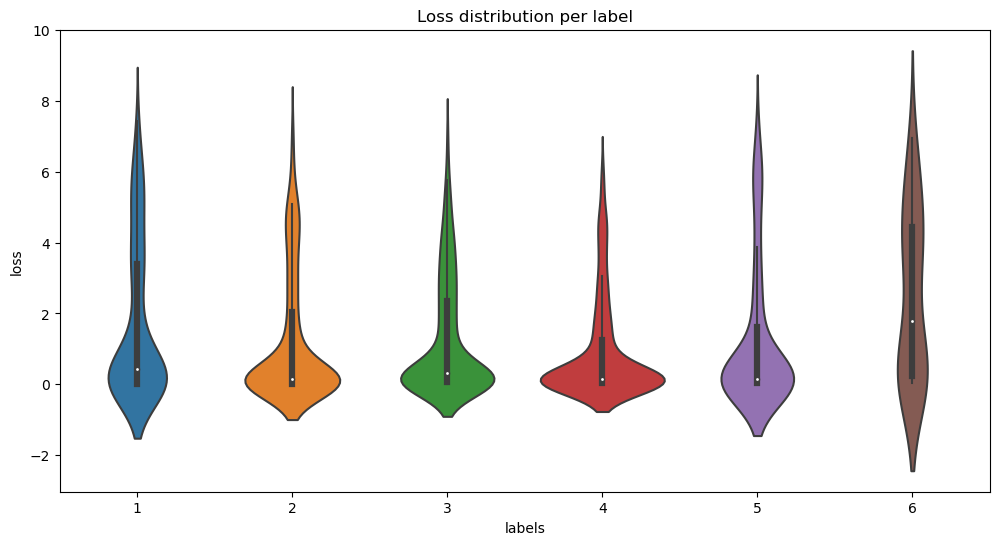

In [145]:
plt.figure(figsize=(12, 6))
sns.violinplot(x="labels", y="loss", data=dataset_pandas)
plt.title("Loss distribution per label")
plt.show()

<img src="./../rsrc/idea.png" alt="Explanation Image" width="50" height="50">

<div style="border: 2px solid red; padding: 10px;">
Very logically, the error distributions are concentrated for the majority classes, and diluted for the minority classes, particularly for class 6. The model will succeed in predicting grades around the average well, and less well when they deviate.
</div>

In [146]:
df_tokens = dataset_pandas.copy()
df_tokens["tokens"] = df_tokens["text"].apply(lambda x: word_tokenize(x))
df_tokens = df_tokens.explode("tokens")
df_tokens = df_tokens.groupby("tokens").agg({"loss": ["mean", "count"]}).reset_index()
df_tokens.columns = ["token", "mean_loss", "count"]
df_tokens = df_tokens.sort_values(by=["mean_loss", "count"], ascending=[False, False], ignore_index=True)


In [147]:
df_tokens.head(10)

,token,mean_loss,count
0,calories,7.392762,2
1,playground,7.268748,1
2,specials,7.268748,1
3,candid,7.193227,1
4,haystack,7.193227,1
5,needle,7.193227,1
6,ray,7.193227,1
7,panning,7.137016,2
8,perring,7.137016,2
9,gangs,7.118694,1


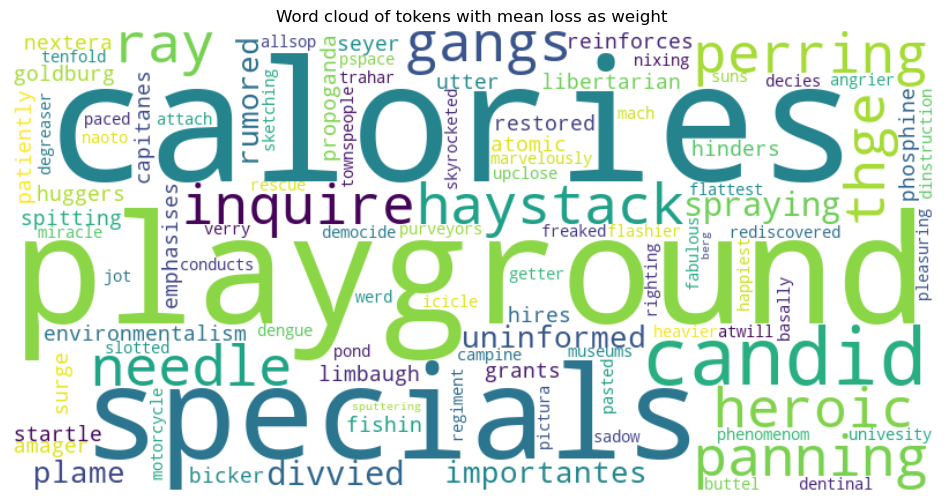

In [148]:
wc = wordcloud.WordCloud(width=800, height=400, max_words=100, background_color="white")
wc.generate_from_frequencies({row["token"]: row["mean_loss"] for _, row in df_tokens.iterrows()})
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word cloud of tokens with mean loss as weight")
plt.show()


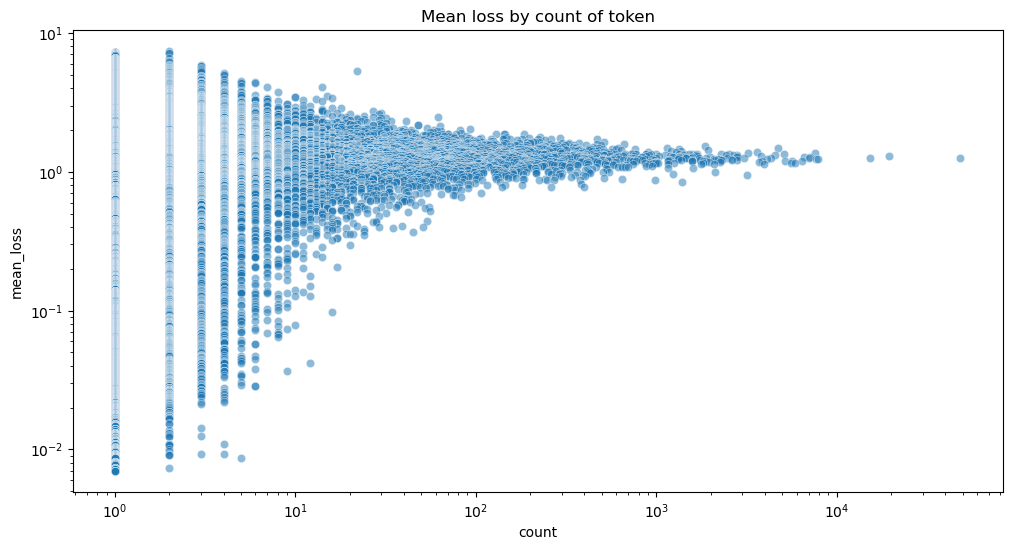

In [149]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x="count", y="mean_loss", data=df_tokens, alpha=0.5)
plt.xscale("log")
plt.yscale("log")
plt.title("Mean loss by count of token")
plt.show()

<img src="./../rsrc/idea.png" alt="Explanation Image" width="50" height="50">

<div style="border: 2px solid red; padding: 10px;">
inevitably the highest errors are concentrated towards the least present words, however we can note that we converge towards a loss of 1 which can still seem quite high.
</div>

In [150]:
model_without_classifier_head = AutoModel.from_pretrained("../training/transformers/gte-base-lazy-teacher-v2",
                                                          trust_remote_code=True).to("mps")

In [151]:
def extract_cls_token(batch):
    inputs = {k: torch.tensor(v).to("mps") for k, v in batch.items() if k in tokenizer.model_input_names}
    model_without_classifier_head.eval()
    with torch.inference_mode():
        outputs = model_without_classifier_head(**inputs)
        cls_tokens = outputs.last_hidden_state[:, 0, :].detach().cpu().numpy()
    return {"cls_tokens": cls_tokens}

In [152]:
data = data.map(extract_cls_token, batched=True, batch_size=4)

Map:   0%|          | 0/2231 [00:00<?, ? examples/s]

In [160]:
cls_tokens = np.stack(data["cls_tokens"])
labels = data["labels"]

scaler = MinMaxScaler()
cls_tokens = scaler.fit_transform(cls_tokens)

reducer = umap.UMAP(n_components=3, random_state=42)
embeddings = reducer.fit_transform(cls_tokens)

/opt/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [ ]:
fig = px.scatter(x=embeddings[:, 0], y=embeddings[:, 1], color=labels, labels={"x": "UMAP 1", "y": "UMAP 2"},
                 title="UMAP embeddings of CLS tokens")

fig.show()

<img src="./../rsrc/idea.png" alt="Explanation Image" width="50" height="50">

<div style="border: 2px solid red; padding: 10px;">
By analyzing the state of the emnbeddings after training, we can clearly see a gradient, from the highest scores to the lowest showing that the learning of the model is tending in a good direction.
</div>

In [170]:
def simple_cleaning(text):
    text = text.lower()
    text = remove_stopwords(text)
    text = stem_text(text)
    
    return text

In [173]:
corpus = [simple_cleaning(text) for text in dataset_pandas["text"]]
corpus = [word_tokenize(text) for text in corpus]
dictionary = Dictionary(corpus)
corpus = [dictionary.doc2bow(text) for text in corpus]

lda = LdaModel(corpus, num_topics=7, id2word=dictionary, random_state=42)

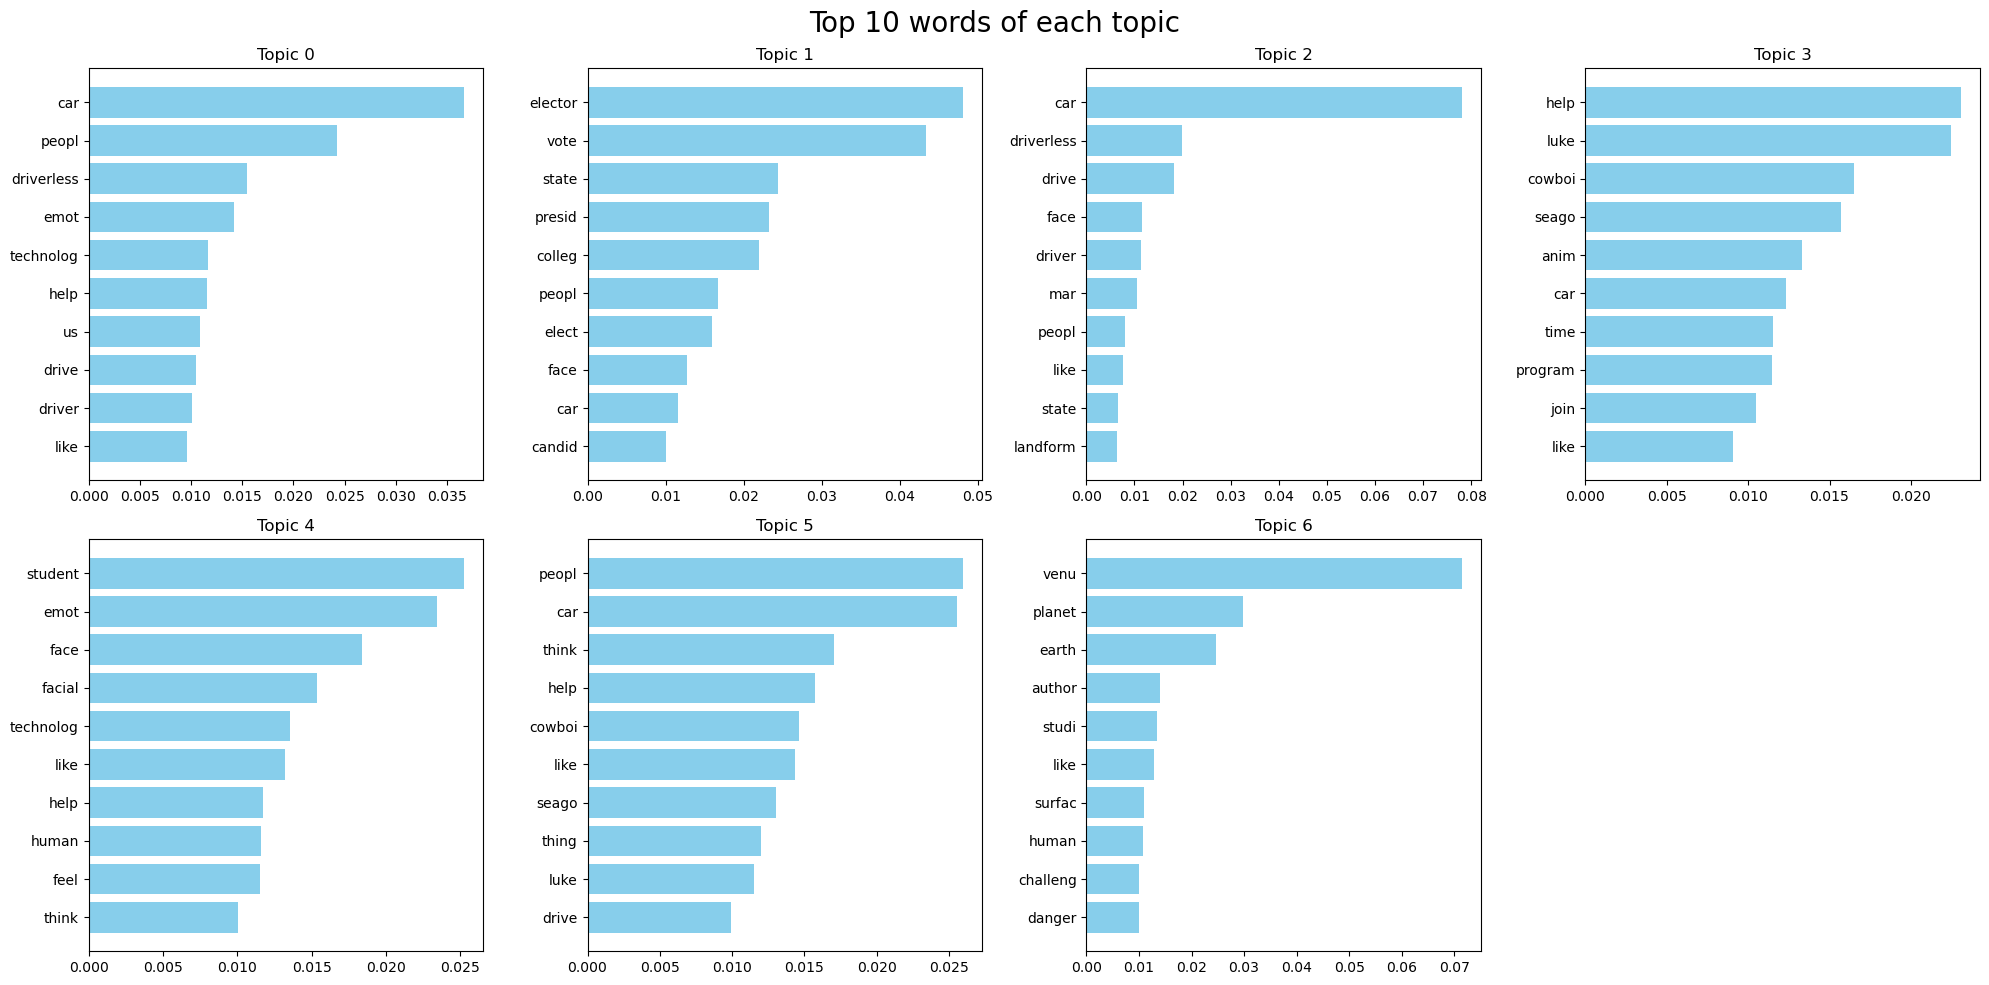

In [174]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for i in range(2):
    for j in range(4):
        topic_index = i * 4 + j
        if topic_index == 7:
            axs[i, j].axis('off')
            break

        topic = lda.show_topic(topic_index, topn=10)
        words, probs = zip(*topic)
        axs[i, j].barh(words, probs, color='skyblue')
        axs[i, j].set_title(f'Topic {topic_index}')
        axs[i, j].invert_yaxis()

plt.suptitle('Top 10 words of each topic', fontsize=20)
plt.tight_layout()

plt.show()

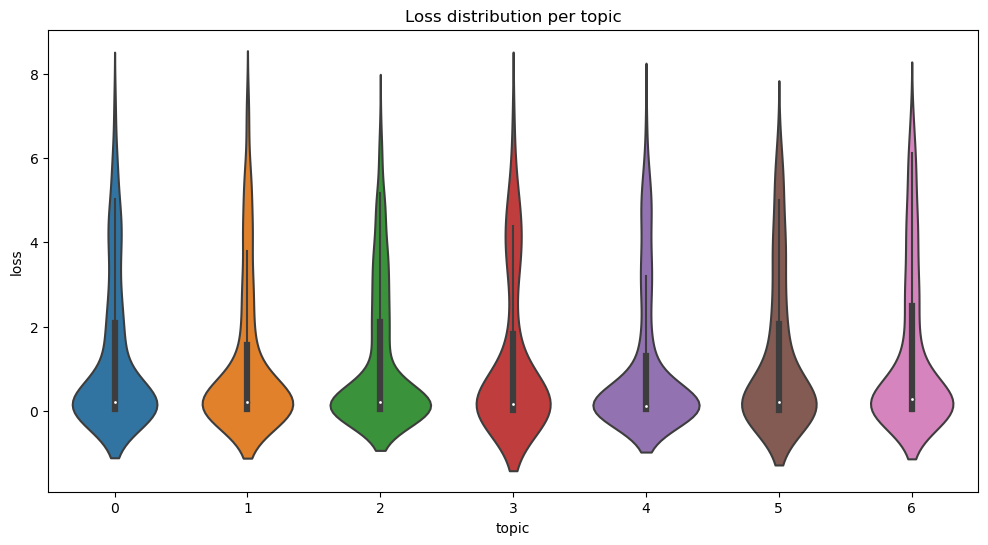

In [175]:
dataset_pandas["cleaned_text"] = dataset_pandas["text"].apply(simple_cleaning)
dataset_pandas["topic"] = [max(lda[text], key=lambda x: x[1])[0] for text in corpus]

plt.figure(figsize=(12, 6))
sns.violinplot(x="topic", y="loss", data=dataset_pandas)
plt.title("Loss distribution per topic")
plt.show()

<img src="./../rsrc/idea.png" alt="Explanation Image" width="50" height="50">

<div style="border: 2px solid red; padding: 10px;">
We analyzed the error distribution by cluster that we noticed in the EDA with the LDA, in order to see if it is more difficult to distinguish the notes of certain subjects, this is not the case.
</div>

In [191]:
dataset_pandas.head(10)

,text,length,ratio_err,labels,loss,preds,cleaned_text,topic
0,the president the united states should decided...,371,0.010782,1,7.418016,2,presid unit state decid elector colleg process...,1
1,limiting the usage your vehicle comes with man...,564,0.005319,2,7.392762,3,limit usag vehicl come advantag environ vehicl...,0
2,the use facial reading computer class seems bi...,432,0.009259,5,7.268748,2,us facial read class bit useless us think less...,4
3,dear state senator believe that the electoral ...,479,0.020877,1,7.193227,2,dear state senat believ elector colleg good th...,1
4,the author claim that nasa working way visit v...,590,0.013559,3,7.137016,4,author claim nasa work wai visit venu despit d...,6
5,should driverless cars actually exist they are...,561,0.010695,5,7.118694,3,driverless car actual exist good bad time driv...,0
6,taking participation the seagoing cowboys prog...,372,0.008065,2,7.088224,3,take particip seago cowboi program differ worl...,3
7,dear state senator this letter would like plam...,448,0.029018,1,7.084138,2,dear state senat letter like plame important e...,1
8,around the world have been seeing trends reduc...,491,0.006110,2,7.065880,3,world see trend reduc automobil usag reduc aut...,0
9,ever since the invention cars people have used...,780,0.006410,3,7.040568,4,invent car peopl everydai travel work pick kid...,2


In [192]:
fig = px.scatter(x=dataset_pandas["length"], y=dataset_pandas["loss"],
                 labels={"x": "Length", "y": "Loss"},
                 title="Loss by length colored by topic")

fig.show()

In [193]:
fig = px.scatter(x=dataset_pandas["ratio_err"], y=dataset_pandas["loss"],
                 labels={"x": "Length", "y": "Loss"},
                 title="Loss by length colored by topic")

fig.show()

In [196]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 12))
    sns.heatmap(cm, annot=False, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion matrix")
    plt.show()

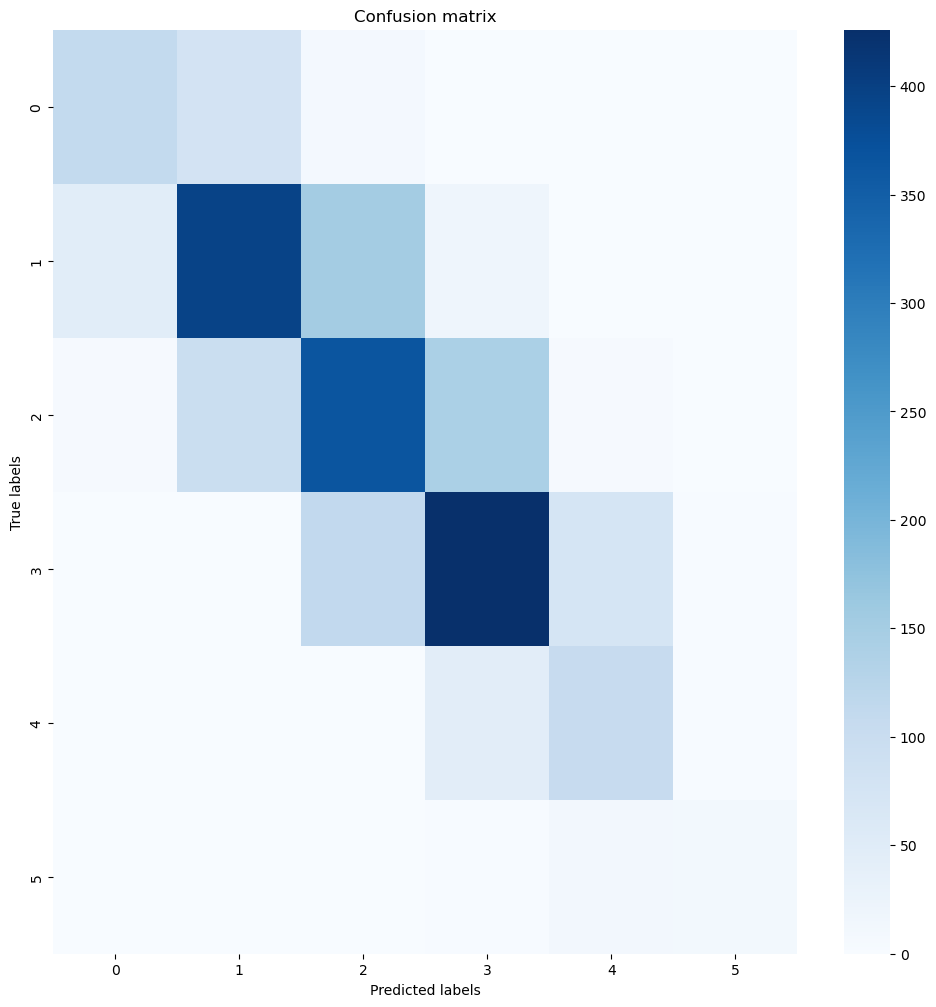

In [197]:
plot_confusion_matrix(dataset_pandas["labels"] - 1, dataset_pandas["preds"], list(range(0, 6)))